In [119]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from tqdm import tqdm
import json
from sklearn.model_selection import GroupKFold
import albumentations as A
import cv2
import pandas as pd
import pydicom as dicom
import json

# Format Data

In [126]:
def permute(image):
    image = torch.Tensor(image)
    image = image.permute(2,0,1).numpy()
    return image

In [127]:
DATA_PATH = '../data/RSNA_dataset/raw_data/stage_2_train_images/'
OUT_PATH = '../data/RSNA_dataset/processed_data/'
TABLE_PATH = '../data/split_tables/RSNA/'
os.makedirs(TABLE_PATH,exist_ok=True)

labels = pd.read_csv('../data/RSNA_dataset/raw_data/stage_2_train_labels.csv')
labels = labels.fillna(0)
labels['cx'] = (labels['x'] + labels['width']/2)/2
labels['cy'] = (labels['y'] + labels['height']/2)/2
labels['h'] =  labels['height']/2
labels['w'] = labels['width']/2
               
labels = labels.drop(['x','y','width','height'],axis=1)

In [128]:
labels

,patientId,Target,cx,cy,h,w
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,0.00,0.00,0.0,0.0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,0.00,0.00,0.0,0.0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0,0.00,0.00,0.0,0.0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,0.00,0.00,0.0,0.0
4,00436515-870c-4b36-a041-de91049b9ab4,1,185.25,170.75,189.5,106.5
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,1,149.50,243.75,189.5,114.0
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,0,0.00,0.00,0.0,0.0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,0,0.00,0.00,0.0,0.0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,1,350.25,282.75,172.5,130.5


In [144]:
patient_list = labels['patientId'].tolist()

In [145]:
for patient in tqdm(patient_list):
    
    image = dicom.dcmread(DATA_PATH+patient+'.dcm').pixel_array
    image = cv2.resize(image, (512,512), interpolation = cv2.INTER_AREA)
    
    target = labels[labels['patientId']==patient]
    
    image = np.stack([image,image,image],axis=0)
    
        
    label = {}
    for i in range(target.shape[0]):
        temp = target.iloc[i].to_dict() 
        for j in temp.keys():
            if j != 'patientId':
                temp[j] = float(temp[j])   
        label[i] = temp 
        
    
    
    #save
    np.save(OUT_PATH+f'/{patient}_image.npy',image)
    
    with open(OUT_PATH+f'/{patient}_label.json', 'w') as outfile:
            json.dump(label, outfile)

100%|██████████| 30227/30227 [15:28<00:00, 32.54it/s]


In [146]:
label

{0: {'patientId': 'c1f7889a-9ea9-4acb-b64c-b737c929599a',
  'Target': 1.0,
  'cx': 350.25,
  'cy': 282.75,
  'h': 172.5,
  'w': 130.5},
 1: {'patientId': 'c1f7889a-9ea9-4acb-b64c-b737c929599a',
  'Target': 1.0,
  'cx': 166.75,
  'cy': 301.0,
  'h': 178.0,
  'w': 100.5}}

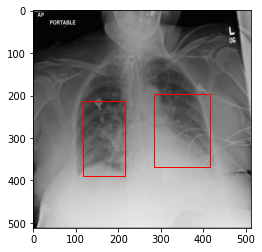

In [147]:
# Create figure and axes
fig, ax = plt.subplots()

ax.imshow(image[0],cmap='gray')

for i in label.keys():
    
    
    rect = patches.Rectangle((label[i]['cx']-label[i]['w']/2, label[i]['cy']-label[i]['h']/2),label[i]['w'] ,label[i]['h'], linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

# Prepare split tables

In [148]:
OUT_PATH

'../data/RSNA_dataset/processed_data/'

In [151]:
images_list = [OUT_PATH[1:]+i for i in os.listdir(OUT_PATH) if i.find('.npy')!=-1]
print(f'Total number of images: {len(images_list)}')

images_list = np.array(images_list)

images_list = np.random.permutation(images_list)

Total number of images: 26684


In [152]:
#create test
kf = GroupKFold(n_splits=5)

for (train,test) in kf.split(images_list,images_list,images_list):
    
    records_test = images_list[test]
    
    
    #create test
    split = {
            'test': records_test.tolist(),
        }
    
    with open(f'{TABLE_PATH}test_split_table.json', 'w') as outfile:
            json.dump(split, outfile)
    break



print(f'Number of images, test subset: {images_list[test].shape[0]}')

images_list = images_list[train]

Number of images, test subset: 5337


In [153]:

#create train and validation
n_patients = [2,4,8]

n = images_list.shape[0]

for i in n_patients:
    
    records_train = images_list[:int(n*(i/100))].tolist()
    
    records_val = images_list[-1*int(n*(2/100)):].tolist()
    
    records_pretrain = images_list[int(n*(i/100)):].tolist()
    
    #create split
    split = {
            'train': records_train,
            'val': records_val,
            'pretrain': records_pretrain,
        }
    with open(f'{TABLE_PATH}{i}_split_table.json', 'w') as outfile:
            json.dump(split, outfile)



            
    print(f'Number of unique images, train subset: {len(records_train)}')
    print(f'Number of samples, val subset: {len(records_val)}')
    print(f'Number of samples, pretain subset: {len(records_pretrain)}')
    print('#######################################################')

    

Number of unique images, train subset: 426
Number of samples, val subset: 426
Number of samples, pretain subset: 20921
#######################################################
Number of unique images, train subset: 853
Number of samples, val subset: 426
Number of samples, pretain subset: 20494
#######################################################
Number of unique images, train subset: 1707
Number of samples, val subset: 426
Number of samples, pretain subset: 19640
#######################################################


In [154]:
#create UB



records_train = images_list[:int(n*0.8)].tolist()
records_train = images_list[:int(n*0.8)].tolist()

records_val = images_list[int(n*0.8):].tolist()



#create split
split = {
        'train': records_train,
        'val': records_val,
    }
with open(f'{TABLE_PATH}UB_split_table.json', 'w') as outfile:
        json.dump(split, outfile)




print(f'Number of unique images, train subset: {len(records_train)}')
print(f'Number of samples, val subset: {len(records_val)}')
print('#######################################################')

Number of unique images, train subset: 17077
Number of samples, val subset: 4270
#######################################################


# Review augs

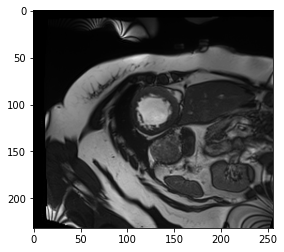

In [148]:
prob = 1
augs = A.Compose(
                [ 
                    A.HorizontalFlip(p=prob),
                    A.VerticalFlip(p=prob),
                    A.Rotate(limit=170, p=prob),
                    A.ElasticTransform(alpha=0.1,p=prob),
                    A.RandomSizedCrop(min_max_height=(120, 120), height=300, width=300, p=prob),
                    A.RandomGamma(gamma_limit=(80, 120), p=prob)
                ]
            )
temp = np.transpose(temp.astype(np.float32), (1, 2, 0))
augmented = augs(image=temp)
temp = np.transpose(temp.astype(np.float32), (2, 0, 1))
image = augmented['image']
image = np.transpose(image.astype(np.float32), (2, 0, 1))

plt.imshow(temp[0],'gray')

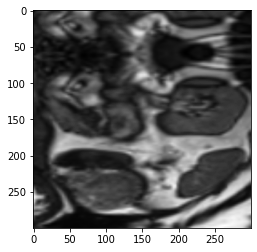

In [149]:
plt.imshow(image[0],'gray')

In [23]:
import numpy as np
import cv2

def rotate_image(image, angle):
    image = np.transpose(image.astype(np.float32), (1, 2, 0))
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    result = np.transpose(result.astype(np.float32), (2, 0, 1))
    return result

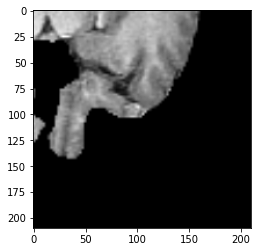

In [24]:
y = rotate_image(image,90)
plt.imshow(y[2],'gray')